<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/Failing%20Water%20Pupm%20Detection%20with%20Tabular%20Learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 9.4 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 4.7 MB 82.1 MB/s 
     |████████████████████████████████| 365 kB 91.8 MB/s 
     |████████████████████████████████| 1.3 MB 81.6 MB/s 
     |████████████████████████████████| 115 kB 56.5 MB/s 
     |████████████████████████████████| 141 kB 82.3 MB/s 
     |████████████████████████████████| 212 kB 74.7 MB/s 
     |████████████████████████████████| 101 kB 14.9 MB/s 
     |████████████████████████████████| 596 kB 96.8 MB/s 
     |████████████████████████████████| 127 kB 81.8 MB/s 
     |████████████████████████████████| 6.6 MB 59.0 MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

#Pump it Up: Data Mining the Water Table
Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all?Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania. [competition link](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/)

## Loading the training and test data set

In [ ]:
import pathlib 
path = pathlib.Path('/content/gdrive/MyDrive/Water')

In [ ]:

Path.BASE_PATH = path

In [ ]:
# load training data
df = pd.read_csv(path/'train.csv', low_memory=False)

In [ ]:
# define target variable
dep_var = 'status_group'

In [ ]:
# load test data for submission
df_test = pd.read_csv('/content/gdrive/MyDrive/Water/test.csv')

We are now ready to explore our first machine learning algorithm for tabular data: decision trees.

## First Model, random forests

We will keep using categorify and fill missing from fastai

In [ ]:
procs = [Categorify, FillMissing]

`TabularPandas` needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function `cont_cat_split`:

In [ ]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
cont

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

In [ ]:
cat

['date_recorded',
 'funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [ ]:
del cont[0] # delete id

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df)) # use 80% for training and 20% for validation

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var,splits=splits)

A `TabularPandas` behaves a lot like a fastai `Datasets` object, including providing `train` and `valid` attributes:

In [ ]:
len(to.train),len(to.valid)

(47520, 11880)

We can see that the data is still displayed as strings for categories (we only show a few columns here because the full table is too big to fit on a page):

In [ ]:
#hide_output
to.show(3)

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
6221,11/2/2012,World Bank,VICTORIA DRILL CO,Kwa Salehe,Lake Victoria,Nyabikere,Mara,Bunda,Nyamuswa,#na#,GeoData Consultants Ltd,#na#,#na#,False,other,other,other,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,machine dbh,borehole,groundwater,other,other,0.0,1332,34.010181,-1.889174,0,20,4,250,2011,non functional
23530,10/18/2012,World Vision,Consuting Engineer,Kakora B,Internal,Kakora,Tabora,Nzega,Itobo,True,GeoData Consultants Ltd,VWC,#na#,False,nira/tanira,nira/tanira,handpump,vwc,user-group,pay when scheme fails,on failure,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,0.0,0,33.025959,-4.235394,0,14,1,0,0,non functional
46633,3/22/2011,Water,Gover,Kilimahewa,Rufiji,Kilimahewa,Dodoma,Mpwapwa,Wotta,True,GeoData Consultants Ltd,VWC,#na#,True,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,0.0,0,36.290272,-6.648475,0,1,1,0,0,functional


However, the underlying items are all numeric:

In [ ]:
#hide_output
to.items.head(3)

,id,amount_tsh,date_recorded,funder,...,source_class,waterpoint_type,waterpoint_type_group,status_group
6221,53999,0.0,81,1866,...,1,7,6,2
23530,70434,0.0,46,1868,...,1,5,4,2
46633,69113,0.0,190,1830,...,1,5,4,0


The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion.

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

We will create random forest and see how it works on the validation test set.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def rf(xs, y, n_estimators=1000, max_samples=20000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs, y);

In [ ]:
yt_pre = m.predict(xs)
yv_pre = m.predict(valid_xs)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y, yt_pre)


0.8596380471380471

In [ ]:
accuracy_score(valid_y, yv_pre)

0.8024410774410774

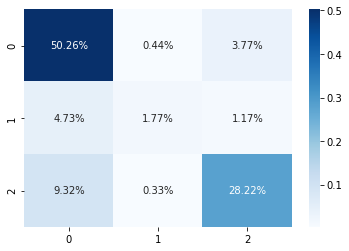

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_y, yv_pre)
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

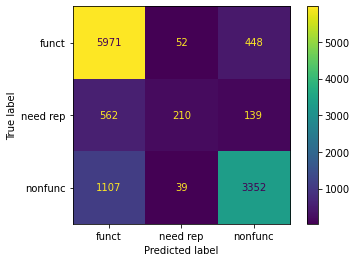

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['funct','need rep','nonfunc'])
disp.plot()
plt.show()

The following code snipped allow us to add the test set, processed and use it for predictions

In [ ]:
to_tst = to.new(df_test)
to_tst.process()
to_tst.items.head()

,id,amount_tsh,date_recorded,funder,...,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,0,308,...,4,2,7,6
1,51630,0.0,0,457,...,7,1,2,2
2,17168,0.0,0,0,...,4,2,7,6
3,45559,0.0,0,396,...,6,1,7,6
4,49871,500.0,0,135,...,7,1,2,2


In [ ]:
m.predict(to_tst[xs.columns])

array([2, 0, 0, ..., 0, 0, 2], dtype=int8)

We will use later to_tst to emsemble the predictions with the ones from the neural network

### Feature Importance to reduce the number of variables

It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with the quantity of water and the location of the pump being the biggest predictors

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
23,quantity,0.105611
24,quantity_group,0.097656
32,longitude,0.071354
33,latitude,0.062691
28,waterpoint_type,0.053870
29,waterpoint_type_group,0.049109
5,subvillage,0.038375
0,date_recorded,0.038352
38,construction_year,0.037763
3,wpt_name,0.037592


A plot of the feature importances shows the relative importances more clearly:

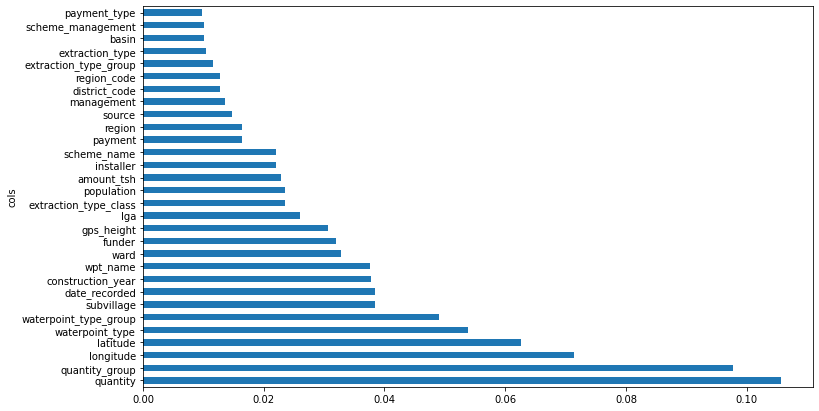

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Removing Low-Importance Variables

It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than 0.005:

In [ ]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

31

We can retrain our model using just this subset of the columns:

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = rf(xs_imp, y)

And here's the result:

In [ ]:
yt_pre = m.predict(xs_imp)
yv_pre = m.predict(valid_xs_imp)


In [ ]:
accuracy_score(y, yt_pre)

0.8582491582491583

In [ ]:
accuracy_score(valid_y, yv_pre)

0.8016835016835017

Our accuracy is about the same, but we have far fewer columns to study:

In [ ]:
len(xs.columns), len(xs_imp.columns)

(39, 31)

##Neural Networks

### Using a Neural Network

We can use the same approach to build a neural network model. Let's first replicate the steps we took to set up the `TabularPandas` object:

In [ ]:
df_nn = pd.read_csv(path/'train.csv', low_memory=False)

As there are high cardinal variables dropped by the random forest, we will use all columns

In [ ]:
df_nn_final= df_nn[list(xs.columns) + [dep_var]]

In [ ]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          59400 non-null  object 
 1   funder                 55765 non-null  object 
 2   installer              55745 non-null  object 
 3   wpt_name               59400 non-null  object 
 4   basin                  59400 non-null  object 
 5   subvillage             59029 non-null  object 
 6   region                 59400 non-null  object 
 7   lga                    59400 non-null  object 
 8   ward                   59400 non-null  object 
 9   public_meeting         56066 non-null  object 
 10  recorded_by            59400 non-null  object 
 11  scheme_management      55523 non-null  object 
 12  scheme_name            31234 non-null  object 
 13  permit                 56344 non-null  object 
 14  extraction_type        59400 non-null  object 
 15  ex

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=5, dep_var=dep_var)

In [ ]:
cont_nn

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

Let's take a look at the cardinality of each of the categorical variables that we have chosen so far:

In [ ]:
df_nn_final[cat_nn].nunique()

date_recorded              356
funder                    1897
installer                 2145
wpt_name                 37400
basin                        9
                         ...  
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
Length: 30, dtype: int64

We can create our `TabularPandas` object in the same way as when we created our random forest, with one very important addition: normalization. A random forest does not need any normalization—the tree building procedure cares only about the order of values in a variable, not at all about how they are scaled. But as we have seen, a neural network definitely does care about this. Therefore, we add the `Normalize` processor when we build our `TabularPandas` object:

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

Tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes:

In [ ]:
dls = to_nn.dataloaders(128)

We can now create the `Learner` to create this tabular model. As usual, we use the application-specific learner function, to take advantage of its application-customized defaults. We set the loss function to MSE, since that's what this competition uses.

By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. This works quite well for small datasets, but here we've got quite a large dataset, so we increase the layer sizes to 700 and 250:

In [ ]:
learn = tabular_learner(dls, layers=[700,250], metrics=accuracy)

SuggestedLRs(valley=0.0005754399462603033)

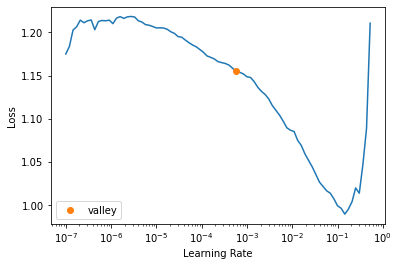

In [ ]:
learn.lr_find()

There's no need to use `fine_tune`, so we'll train with `fit_one_cycle` for a few epochs and see how it looks:

In [ ]:
learn.fit_one_cycle(1, 0.0005,wd=0.25)

epoch,train_loss,valid_loss,accuracy,time
0,0.584472,0.572664,0.781482,00:05


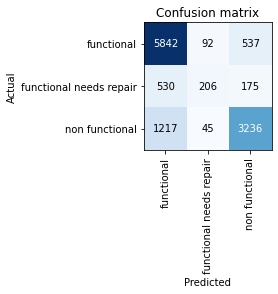

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
df_test = pd.read_csv('/content/gdrive/MyDrive/Water/test.csv')

In [ ]:
del (df_test['id'])

In [ ]:
to_test = TabularPandas(df_test, procs, cat_nn, cont_nn)

In [ ]:
test_dl = dls.test_dl(df_test, with_labels=False)

In [ ]:
preds = learn.get_preds(dl=test_dl)

In [ ]:
import pandas as pd
#preds[0]

pada = pd.DataFrame(preds[0]).astype("float")

In [ ]:
pada['pred'] = pada.apply(lambda x: x.argmax(), axis=1)

In [ ]:
pada['pred'].value_counts()

0    9472
2    4961
1     417
Name: pred, dtype: int64

In [ ]:
pada.columns = ['0','1','2','pred']

In [ ]:
df_test_id = pd.read_csv('/content/gdrive/MyDrive/Water/test.csv')

In [ ]:
df_test_id =  pd.concat([df_test_id, pada],axis=1)

In [ ]:
submission = pd.read_csv('/content/gdrive/MyDrive/Water/SubmissionFormat.csv')

In [ ]:
df_test_id = pd.merge(df_test_id[['id','0', '1', '2', 'pred']],submission,on = 'id' )

In [ ]:
df_test_id.columns

Index(['id', '0', '1', '2', 'pred', 'status_group'], dtype='object')

In [ ]:
df_test_id.loc[df_test_id['pred'] == 0, 'status_group'] = 'functional'
df_test_id.loc[df_test_id['pred'] == 1, 'status_group'] = 'functional needs repair'
df_test_id.loc[df_test_id['pred'] == 2, 'status_group'] = 'non functional'

In [ ]:
df_test_id['status_group'].value_counts()

functional                 9472
non functional             4961
functional needs repair     417
Name: status_group, dtype: int64

In [ ]:
df_test_id['rf'] = np.nan

In [ ]:
df_test_id.loc[:,'rf'] = m.predict(to_tst[xs_imp.columns])

In [ ]:
df_test_id['status_group'].value_counts()

functional                 9472
non functional             4961
functional needs repair     417
Name: status_group, dtype: int64

we will use the random forest every time the neural net is not confident about the results, so the prob of the class is less than 70%

In [ ]:
df_test_id.loc[(df_test_id['0'] < 0.7) & (df_test_id['pred'] == 0), 'status_group'] = 'rf'
df_test_id.loc[(df_test_id['1'] < 0.7) & (df_test_id['pred'] == 1), 'status_group'] = 'rf'
df_test_id.loc[(df_test_id['2'] < 0.7) & (df_test_id['pred'] == 2), 'status_group'] = 'rf'

In [ ]:
df_test_id.loc[(df_test_id['status_group'] == 'rf'), 'status_group'] = df_test_id.loc[(df_test_id['status_group'] == 'rf'), 'rf'] 

In [ ]:
df_test_id.loc[(df_test_id['status_group']  == 0), 'status_group'] = 'functional'
df_test_id.loc[(df_test_id['status_group']  == 1), 'status_group'] = 'functional needs repair'
df_test_id.loc[(df_test_id['status_group']  == 2), 'status_group'] = 'non functional'

In [ ]:
df_test_id.to_csv('solution2.csv')

By using only the NN when is 70% certain I reach 80%, which is only 2pp from state of the art